In [ ]:
!unzip '/content/drive/MyDrive/DC5.zip' -d '/content/dogata'

from IPython.display import clear_output

clear_output()

#Added the breed "Samoyed"
#Erased dhole (it is not a type of dog) from the original data
#Corrected American Spaniel folder name- caused problems when splitting the data
#Modified English bulldog (The initial data mixed pictures of english bulldogs with french bulldogs)
#Modified the Boston Terrier. Initial data also contained images of french bulldogs (ears are the main visual difference)

In [ ]:
from google.colab import runtime
runtime.unassign()


In [ ]:
train_dir = "/content/dogata/DC2/train"
val_dir = "/content/dogata/DC2/valid"
test_dir = "/content/dogata/DC2/test"


In [ ]:
#Deterministic code
#though may reduaccuracy a bit, having more test samples should improve generalizability
import os
import shutil
###import random (If you want to randomize the images transferred)
# define your directories
root_dir = "/content/dogata/DC2"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
valid_dir = os.path.join(root_dir, "valid")

# get the list of classes
classes = os.listdir(train_dir)

# for each class, move 5 images from train to test and valid
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)

    # create the class directory in test and valid if it does not exist
    os.makedirs(test_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)

    # get a list of images in the train directory for this class
    images = sorted(os.listdir(train_class_dir))
    ###random.shuffle(images) (If you want to randomize the images transferred)
    # select the first 10 images to move
    images_to_move = images[:10]

    # move 5 images to test
    for i, image in enumerate(images_to_move[:5]):
        new_name = f"{class_name}_test_{i}.jpg"  # change the extension if needed
        shutil.move(os.path.join(train_class_dir, image), os.path.join(test_class_dir, new_name))

    # move 5 images to valid
    for i, image in enumerate(images_to_move[5:]):
        new_name = f"{class_name}_valid_{i}.jpg"  # change the extension if needed
        shutil.move(os.path.join(train_class_dir, image), os.path.join(valid_class_dir, new_name))


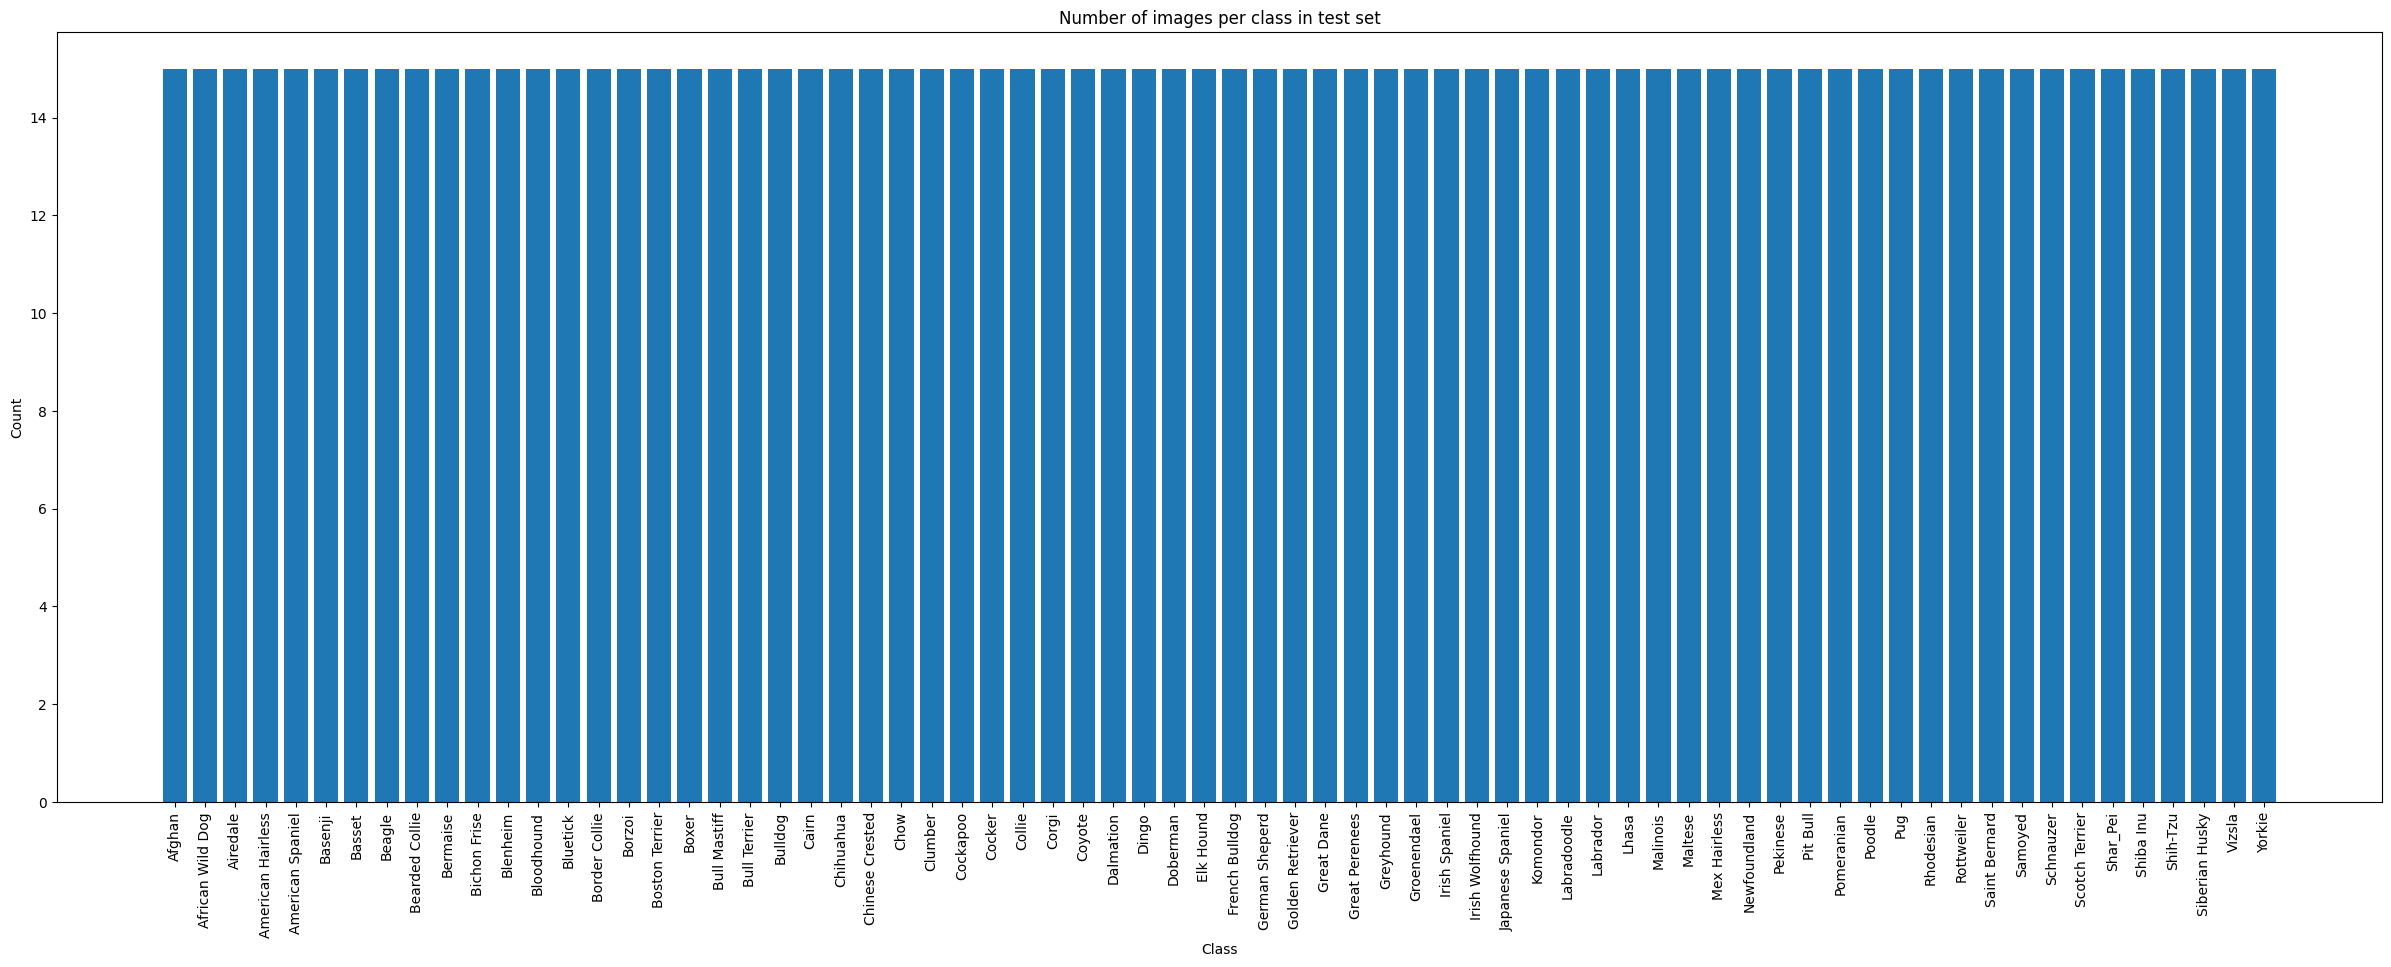

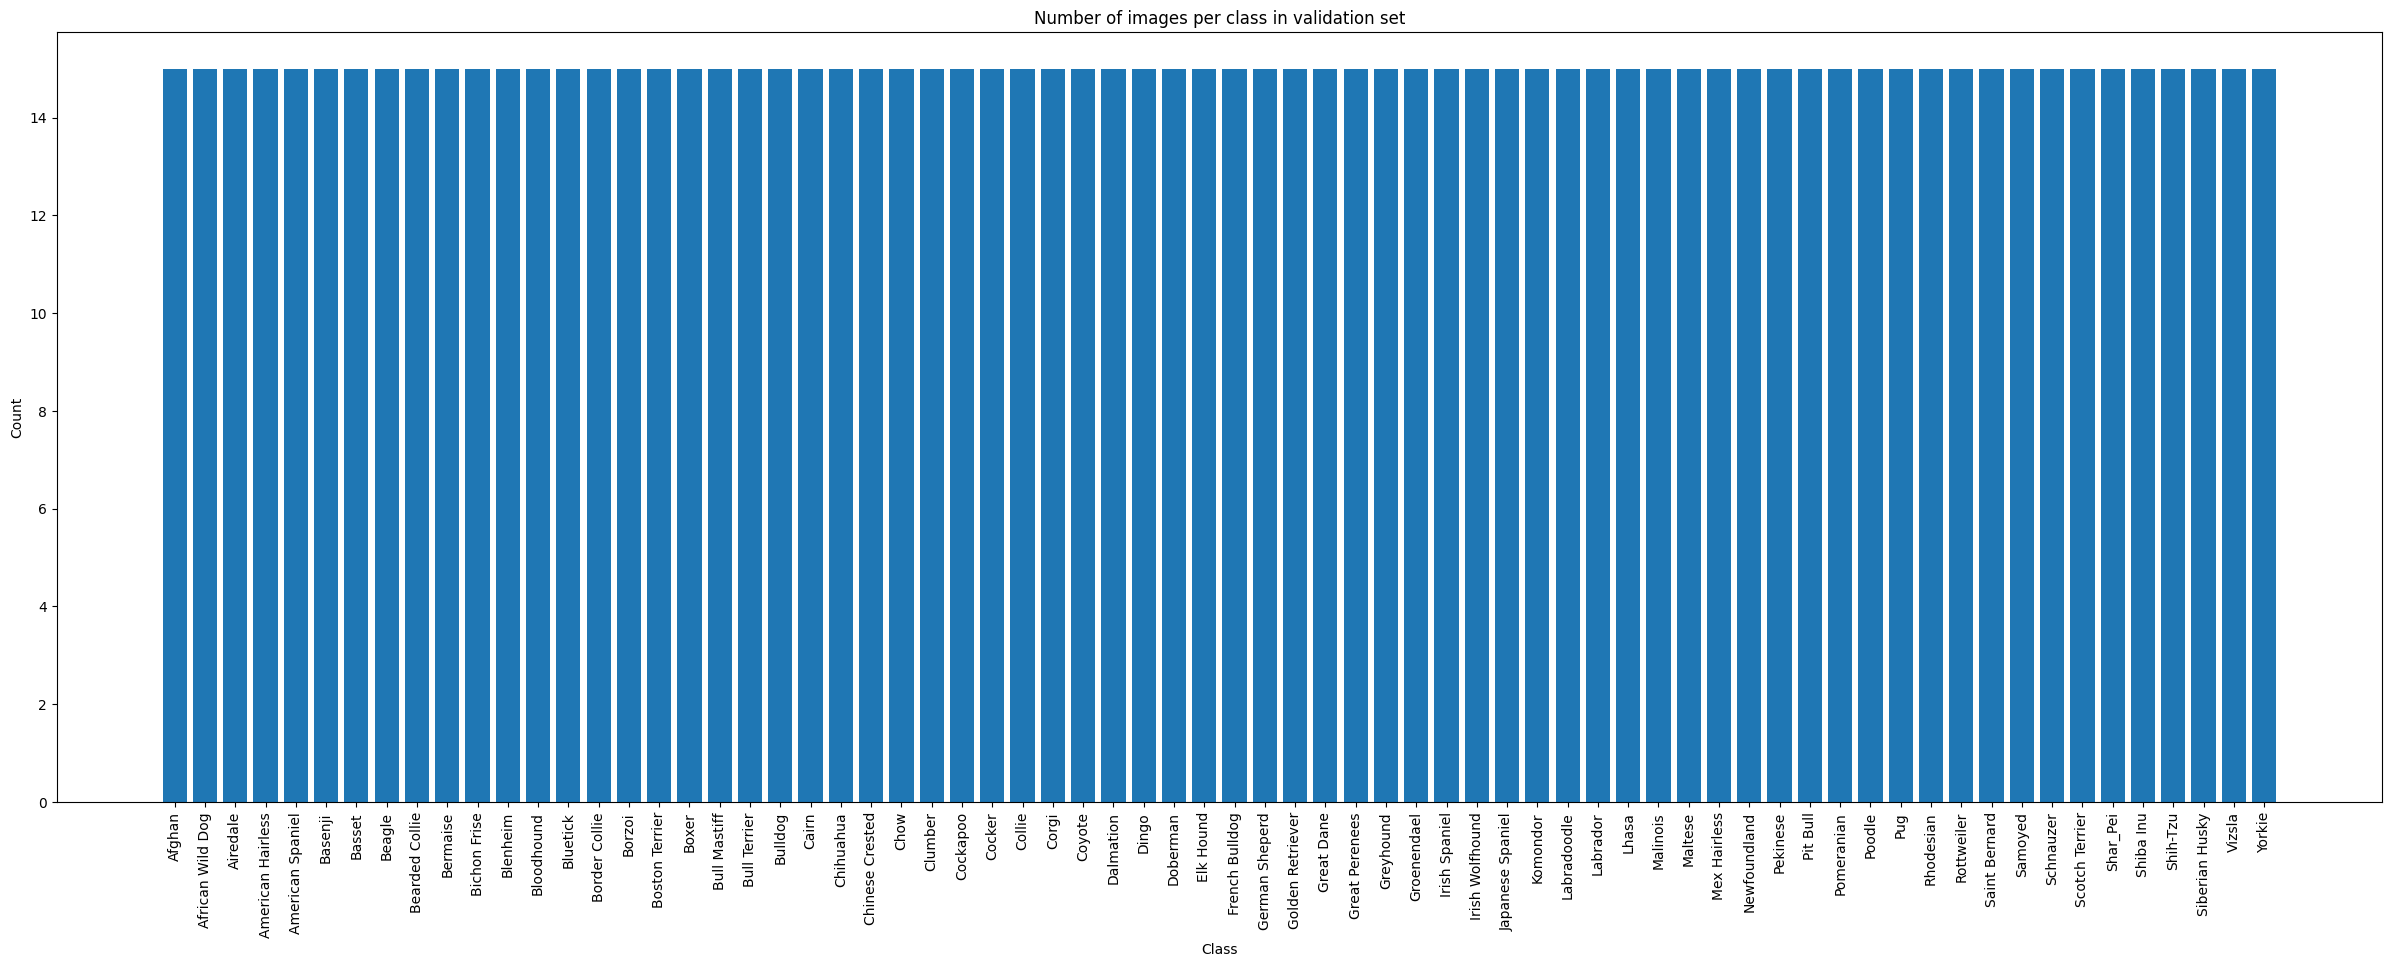

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_histogram(directory, title):
    classes = os.listdir(directory)
    counts = [len(os.listdir(os.path.join(directory, cls))) for cls in classes]
    df = pd.DataFrame(list(zip(classes, counts)), columns=['Class', 'Count'])
    df = df.sort_values('Class')
    plt.figure(figsize=(30,10))
    plt.bar(df['Class'], df['Count'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation='vertical')
    plt.show()

# Now you can call the function for each directory
plot_histogram(test_dir, 'Number of images per class in test set')
plot_histogram(valid_dir, 'Number of images per class in validation set')


In [ ]:
pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
# Set up CUDA in OS

# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import time
import copy


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
use_cuda = torch.cuda.is_available()

if torch.cuda.is_available():
  print("CUDA is available!")
else:
  print("CUDA is not available.")

CUDA is available!


In [ ]:
import wandb

model_name = "resnet18"
mod = getattr(models, model_name)

lr = .016142535033592663
num_epochs = 25
batch_size = 64

wandb.login()
wandb.init(
    project="Dog Classification Project",
    config={
        "learning_rate": lr,
        "batch_size": batch_size,
        "model_architecture": model_name,  # Use the model name string here
        "epochs": num_epochs,
    }
)



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chrismontes22. Use `wandb login --relogin` to force relogin


In [ ]:
transforms_train = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    v2.CenterCrop((224, 224)),# data augmentation
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    v2.Resize((224, 224), antialias=True),   #must same as here
    v2.CenterCrop((224, 224)),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transforms_test)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



NameError: name 'batch_size' is not defined

In [ ]:
print('Train dataset size:', len(train_dataset))
print('Total classes:', len(train_dataset.classes))  # Use train_dataset as an example
print('Unique classes in train dataset:', len(set(train_dataset.targets)))

print('Validation dataset size:', len(val_dataset))
print('Total classes:', len(val_dataset.classes))  # Use val_dataset as an example
print('Unique classes in validation dataset:', len(set(train_dataset.targets)))

print('Test dataset size:', len(test_dataset))
print('Total classes:', len(test_dataset.classes))  # Use test_dataset as an example
print('Unique classes in test dataset:', len(set(test_dataset.targets)))

class_names = train_dataset.classes
print('Class names:', class_names)



Train dataset size: 7892
Total classes: 70
Unique classes in train dataset: 70
Validation dataset size: 700
Total classes: 70
Unique classes in validation dataset: 70
Test dataset size: 700
Total classes: 70
Unique classes in test dataset: 70
Class names: ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pi

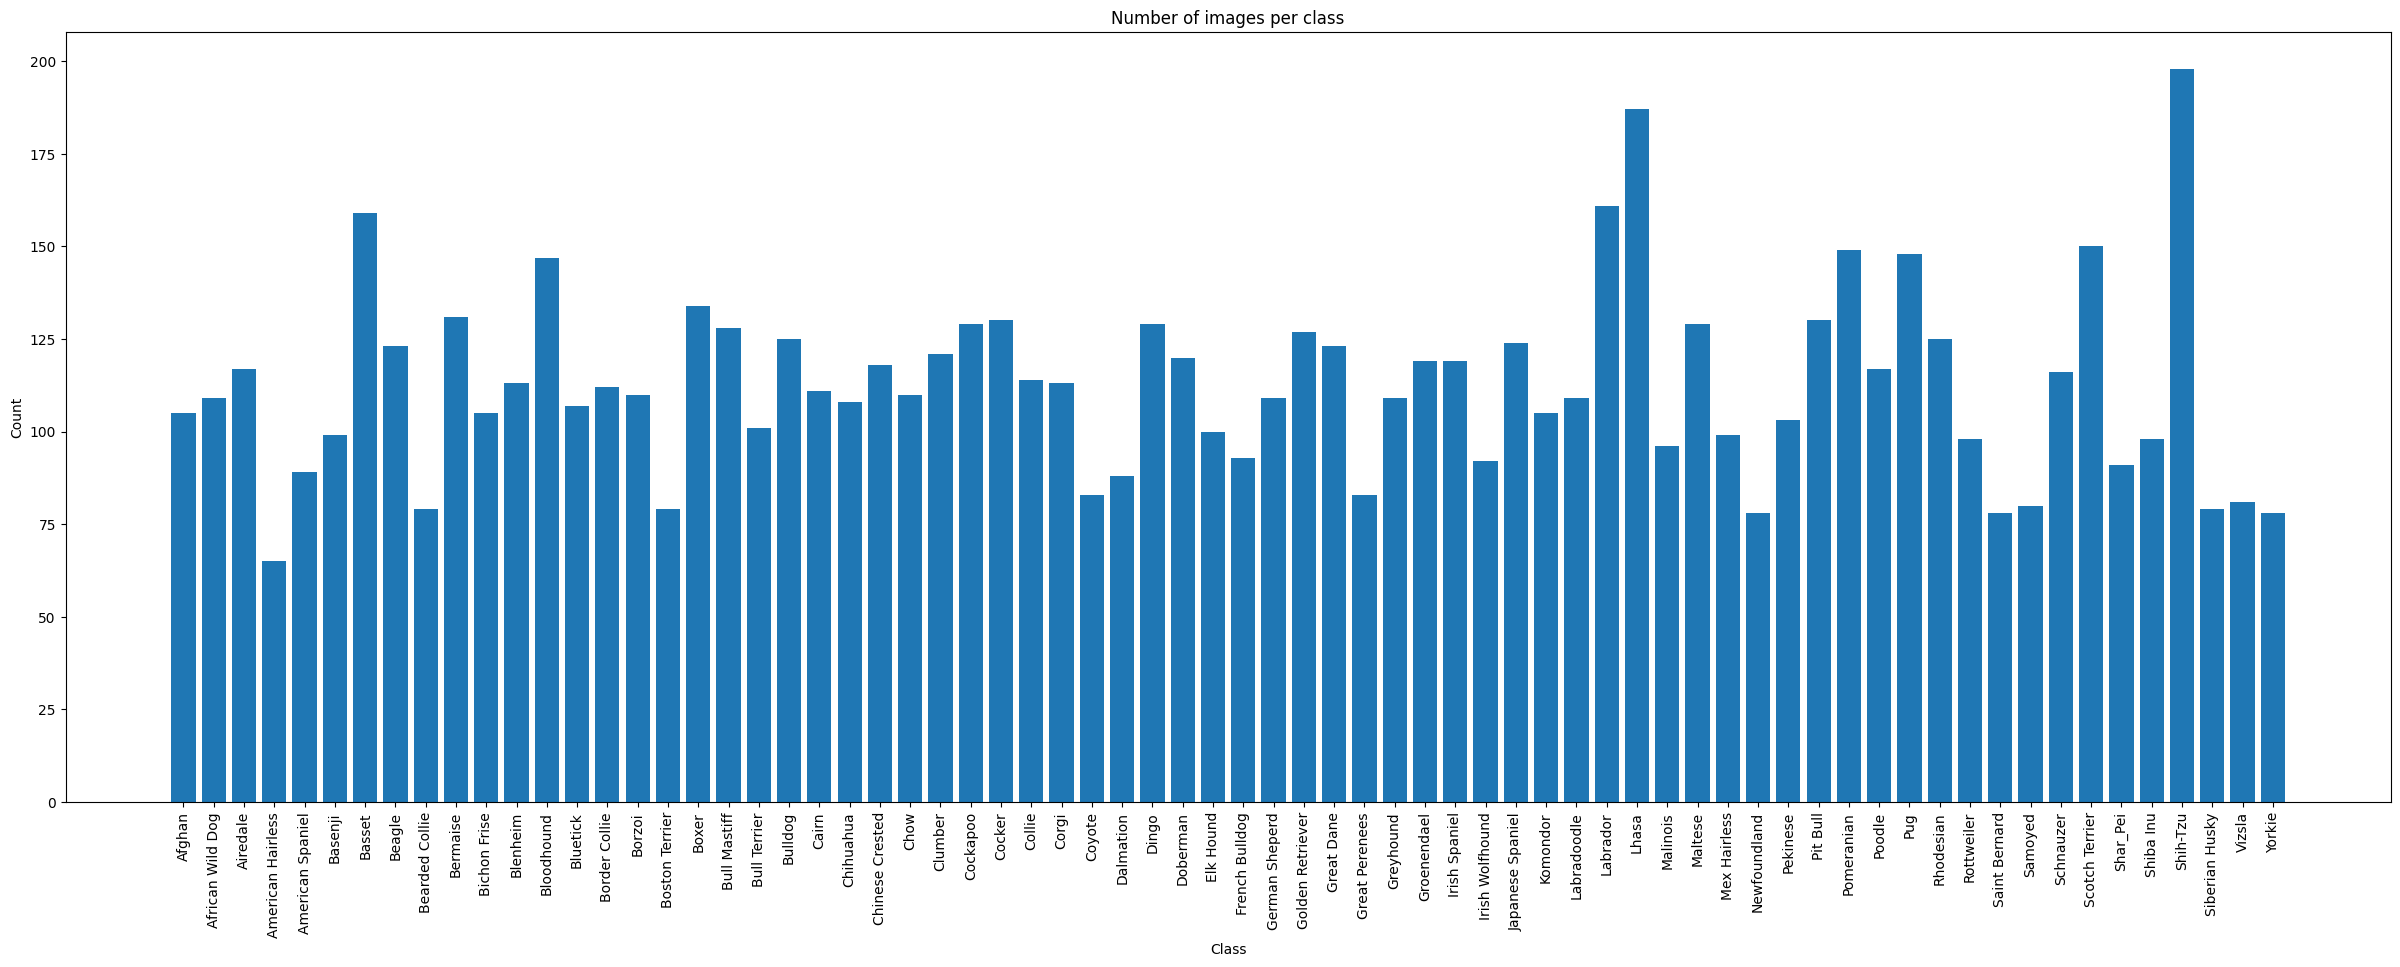

In [ ]:
# Get the list of all classes
classes = os.listdir(train_dir)

# Count the number of images in each class
counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]

# Create a DataFrame
df = pd.DataFrame(list(zip(classes, counts)), columns=['Class', 'Count'])

# Sort the DataFrame by Class
df = df.sort_values('Class')

# Create a histogram
plt.figure(figsize=(30,10))
plt.bar(df['Class'], df['Count'])
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Find the class with the minimum number of images
min_class = min(counts, key=counts.get)
min_count = counts[min_class]

# Find the class with the maximum number of images
max_class = max(counts, key=counts.get)
max_count = counts[max_class]

print(f'The dog class with the lowest number of images is "{min_class}" with {min_count} images.')
print(f'The dog class with the highest number of images is "{max_class}" with {max_count} images.')


import numpy as np

def gini_index(arr):
    # (Warning: This is a simplified version and does not account for zero elements)
    arr = np.array(arr, dtype=np.float32)
    arr = arr / np.sum(arr)
    arr = np.sort(arr)
    index = np.arange(1, arr.shape[0] + 1)
    n = arr.shape[0]
    return ((np.sum((2 * index - n  - 1) * arr)) / n)

counts_values = list(counts.values())
gini = gini_index(counts_values)
print(f"Gini Index: {gini}")

#The imbalance in data is low


The dog class with the lowest number of images is "American Hairless" with 65 images.
The dog class with the highest number of images is "Shih-Tzu" with 198 images.
Gini Index: 0.11656538502180151


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_loader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

NameError: name 'train_loader' is not defined

In [ ]:
# Load the pre-trained model
model = mod(pretrained=True)
#print(model)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Unfreeze the last layer, only necessary if you also froze the FC along the tohers
"""for param in model.fc.parameters():
    param.requires_grad = True"""

# Modify the last layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 70)


# Move the model to the device
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 22.7MB/s]


In [ ]:
from sklearn.metrics import f1_score

def compute_f1_score(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(inputs)

        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.detach().cpu().numpy())
        pred_labels.extend(predictions.detach().cpu().numpy())

    f1 = f1_score(true_labels, pred_labels, average='macro')
    return f1


def compute_accuracy(model, dataloader):
    model.eval()
    correct = 0.0
    total_examples = 0
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)
    accuracy = correct / total_examples
    return accuracy.item()  # return a Python scalar


import torch.nn.functional as F


optimizer = torch.optim.SGD(model.parameters(), lr=lr)



loss_list = []
train_acc_list, val_acc_list = [], []

start_time = time.time()
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_f1 = compute_f1_score(model, train_loader)
    val_f1 = compute_f1_score(model, val_loader)
    print(f"Train F1 {train_f1*100:.2f}% | Val F1 {val_f1*100:.2f}%")

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    wandb.log({"acc": val_acc, "loss": loss, "F1 Macro": val_f1 })

test_acc = compute_accuracy(model, test_loader)
print(f"Test Acc {test_acc*100:.2f}%")
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

#possibly epoch 26 is the best


Epoch: 001/025 | Batch 000/112 | Train Loss: 4.42
Train F1 59.89% | Val F1 59.95%
Train Acc 64.76% | Val Acc 62.86%
Epoch: 002/025 | Batch 000/112 | Train Loss: 2.02
Train F1 80.42% | Val F1 81.86%
Train Acc 81.35% | Val Acc 82.86%
Epoch: 003/025 | Batch 000/112 | Train Loss: 1.61
Train F1 86.30% | Val F1 88.10%
Train Acc 86.63% | Val Acc 88.29%
Epoch: 004/025 | Batch 000/112 | Train Loss: 1.02
Train F1 87.82% | Val F1 89.28%
Train Acc 88.32% | Val Acc 89.43%
Epoch: 005/025 | Batch 000/112 | Train Loss: 0.79
Train F1 89.48% | Val F1 91.14%
Train Acc 89.06% | Val Acc 91.14%
Epoch: 006/025 | Batch 000/112 | Train Loss: 0.76
Train F1 90.21% | Val F1 91.36%
Train Acc 90.24% | Val Acc 91.43%
Epoch: 007/025 | Batch 000/112 | Train Loss: 0.63
Train F1 90.85% | Val F1 91.35%
Train Acc 90.76% | Val Acc 91.33%
Epoch: 008/025 | Batch 000/112 | Train Loss: 0.71
Train F1 91.21% | Val F1 91.80%
Train Acc 91.04% | Val Acc 91.81%
Epoch: 009/025 | Batch 000/112 | Train Loss: 0.46
Train F1 91.72% | Val 

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "DogID2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/DogID2.pth


In [ ]:
wandb.finish()

F1 Macro,▁▆▇▇▇████████████████████
acc,▁▆▇▇▇█▇██████████████████
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁
F1 Macro,0.93717
acc,0.93619
loss,0.28236


In [ ]:
def compute_top5_accuracy(model, dataloader):
    model.eval()
    correct = 0.0
    total_examples = 0
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        top5_preds = torch.topk(logits, 5, dim=1)[1]
        correct += torch.sum(top5_preds == labels.view(-1, 1).expand_as(top5_preds)).item()
        total_examples += len(labels)
    top5_accuracy = correct / total_examples
    return top5_accuracy
test_top5_acc = compute_top5_accuracy(model, test_loader)
print(f"Test Top-5 Acc: {test_top5_acc*100:.2f}%")


Test Top-5 Acc: 100.00%


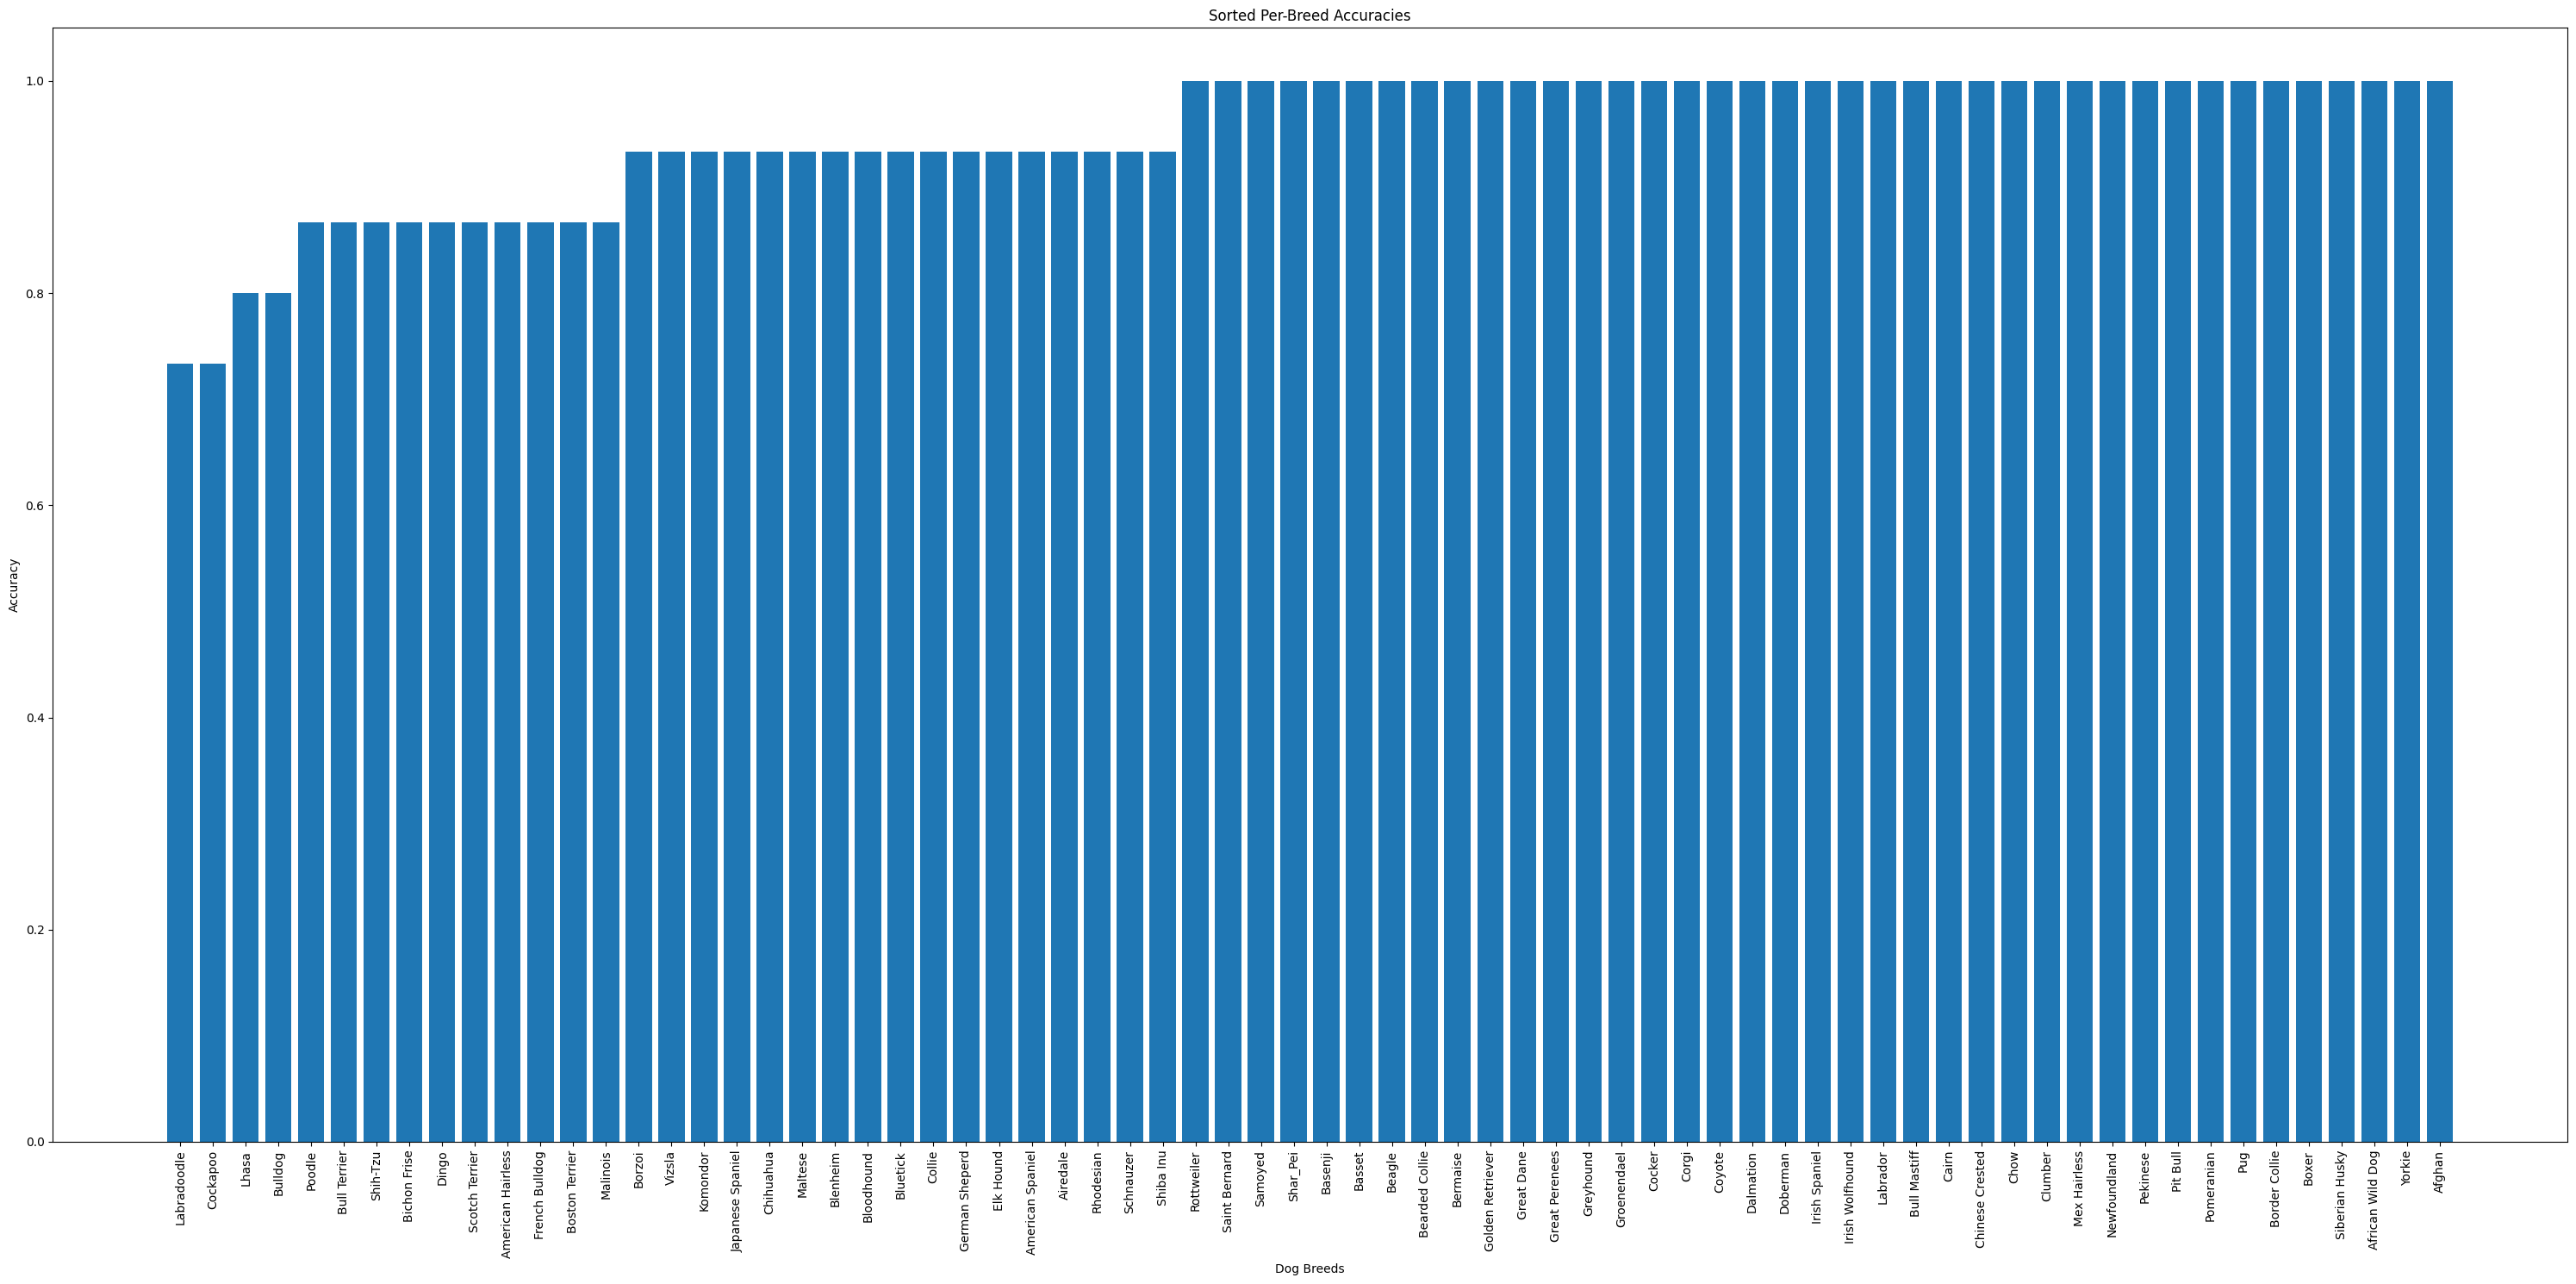

Test Acc for class Labradoodle: 73.33%
Test Acc for class Cockapoo: 73.33%
Test Acc for class Lhasa: 80.00%
Test Acc for class Bulldog: 80.00%
Test Acc for class Poodle: 86.67%
Test Acc for class Bull Terrier: 86.67%
Test Acc for class Shih-Tzu: 86.67%
Test Acc for class Bichon Frise: 86.67%
Test Acc for class Dingo: 86.67%
Test Acc for class Scotch Terrier: 86.67%
Test Acc for class American Hairless: 86.67%
Test Acc for class French Bulldog: 86.67%
Test Acc for class Boston Terrier: 86.67%
Test Acc for class Malinois: 86.67%
Test Acc for class Borzoi: 93.33%
Test Acc for class Vizsla: 93.33%
Test Acc for class Komondor: 93.33%
Test Acc for class Japanese Spaniel: 93.33%
Test Acc for class Chihuahua: 93.33%
Test Acc for class Maltese: 93.33%
Test Acc for class Blenheim: 93.33%
Test Acc for class Bloodhound: 93.33%
Test Acc for class Bluetick: 93.33%
Test Acc for class Collie: 93.33%
Test Acc for class German Sheperd: 93.33%
Test Acc for class Elk Hound: 93.33%
Test Acc for class Ameri

In [ ]:
def compute_per_class_accuracy(model, dataloader, num_classes):
    model.eval()
    correct_per_class = [0.0] * num_classes
    total_per_class = [0.0] * num_classes
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        for i in range(num_classes):
            correct_per_class[i] += torch.sum((predictions == i) & (labels == i)).item()
            total_per_class[i] += torch.sum(labels == i).item()
    accuracy_per_class = [correct / total if total > 0 else 0 for correct, total in zip(correct_per_class, total_per_class)]
    return accuracy_per_class  # return a list of Python scalars
class_names = train_dataset.classes

# Compute per-class accuracy for the test set after training
test_per_class_acc = compute_per_class_accuracy(model, test_loader, num_classes=len(train_dataset.classes))

sorted_indices = np.argsort(test_per_class_acc)
sorted_accuracies = np.array(test_per_class_acc)[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]

# Create a sorted bar plot for accuracies
plt.figure(figsize=(30, 15))  # Adjust as needed
plt.bar(sorted_class_names, sorted_accuracies)
plt.xlabel('Dog Breeds')
plt.ylabel('Accuracy')
plt.title('Sorted Per-Breed Accuracies')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if dog breeds are long
plt.tight_layout()  # Ensure that labels fit into the figure area
plt.show()
# Get the class names


for i, acc in enumerate(sorted_accuracies):
    print(f"Test Acc for class {sorted_class_names[i]}: {acc*100:.2f}%")

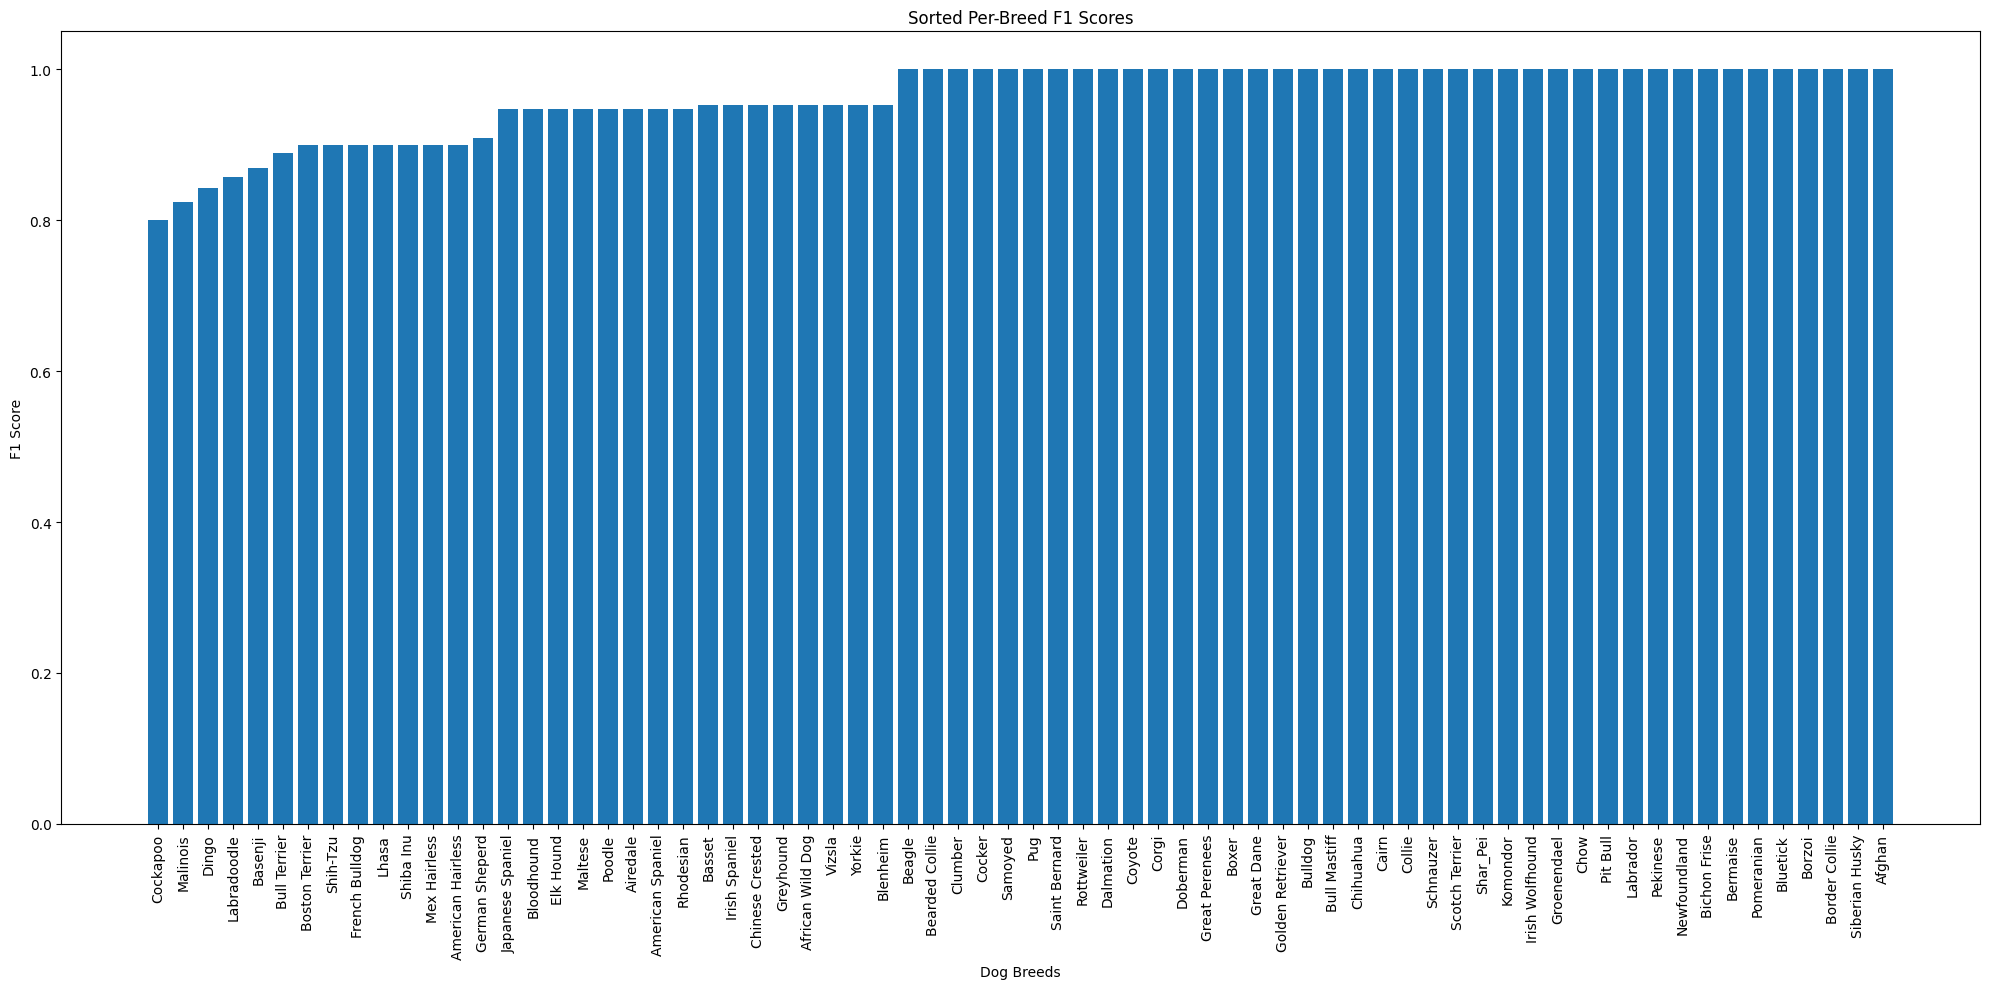

F1 Score for Cockapoo: 0.80
F1 Score for Malinois: 0.82
F1 Score for Dingo: 0.84
F1 Score for Labradoodle: 0.86
F1 Score for Basenji: 0.87
F1 Score for Bull Terrier: 0.89
F1 Score for Boston Terrier: 0.90
F1 Score for Shih-Tzu: 0.90
F1 Score for French Bulldog: 0.90
F1 Score for Lhasa: 0.90
F1 Score for Shiba Inu: 0.90
F1 Score for Mex Hairless: 0.90
F1 Score for American Hairless: 0.90
F1 Score for German Sheperd: 0.91
F1 Score for Japanese Spaniel: 0.95
F1 Score for Bloodhound: 0.95
F1 Score for Elk Hound: 0.95
F1 Score for Maltese: 0.95
F1 Score for Poodle: 0.95
F1 Score for Airedale: 0.95
F1 Score for American Spaniel: 0.95
F1 Score for Rhodesian: 0.95
F1 Score for Basset: 0.95
F1 Score for Irish Spaniel: 0.95
F1 Score for Chinese Crested: 0.95
F1 Score for Greyhound: 0.95
F1 Score for African Wild Dog: 0.95
F1 Score for Vizsla: 0.95
F1 Score for Yorkie: 0.95
F1 Score for Blenheim: 0.95
F1 Score for Beagle: 1.00
F1 Score for Bearded Collie: 1.00
F1 Score for Clumber: 1.00
F1 Score 

In [ ]:


def compute_f1_score_per_class(model, dataloader, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.detach().cpu().numpy())
        predicted_labels.extend(predictions.detach().cpu().numpy())
    f1_scores = f1_score(true_labels, predicted_labels, average=None)  # 'None' for scores for each class
    return f1_scores  # return a list of Python scalars
# Compute F1 score for each class in the test set after training
# Compute F1 score for each class in the test set after training
# Compute F1 score for each class in the test set after training
test_f1_scores = compute_f1_score_per_class(model, test_loader, num_classes=len(train_dataset.classes))
class_names = train_dataset.classes  # Assuming class_names are your dog breeds

# Sort the scores and corresponding class names
sorted_indices = np.argsort(test_f1_scores)
sorted_f1_scores = test_f1_scores[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]
# Create a sorted bar plot for F1 scores
plt.figure(figsize=(20, 10))  # Adjust as needed
plt.bar(sorted_class_names, sorted_f1_scores)
plt.xlabel('Dog Breeds')
plt.ylabel('F1 Score')
plt.title('Sorted Per-Breed F1 Scores')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if dog breeds are long
plt.tight_layout()  # Ensure that labels fit into the figure area
plt.show()

class_names = train_dataset.classes  # Assuming class_names are your dog breeds
for i, f1 in enumerate(sorted_f1_scores):
    print(f"F1 Score for {sorted_class_names[i]}: {f1:.2f}")


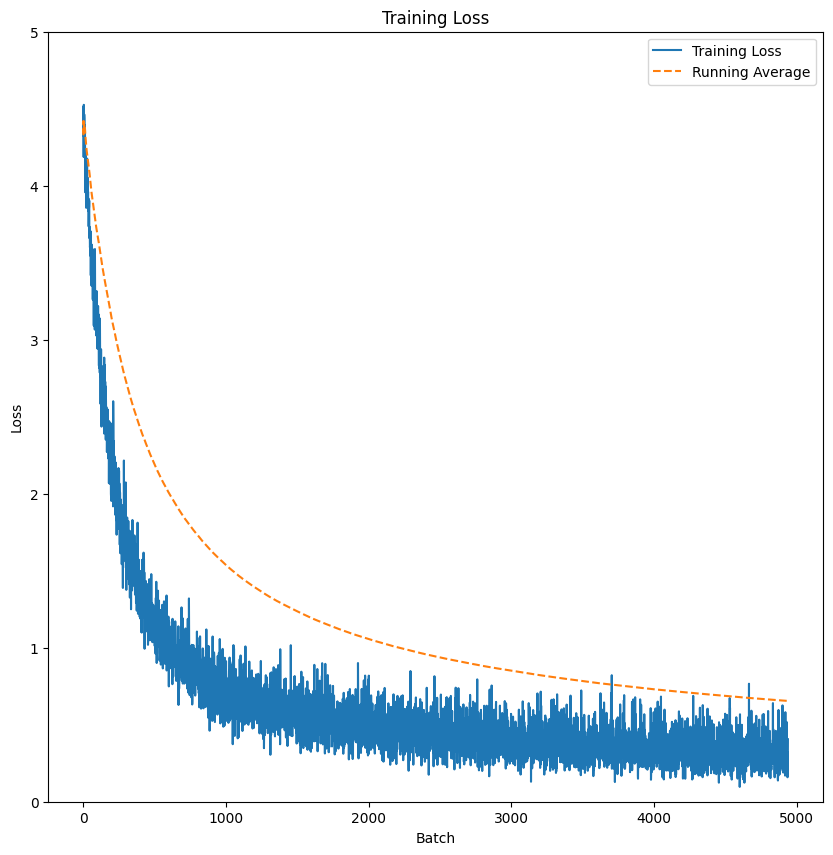

In [ ]:
# Calculate the running average
running_avg_loss = np.cumsum(loss_list) / np.arange(1, len(loss_list) + 1)

# Plot the training loss and the running average
plt.figure(figsize=(10, 10))
plt.plot(loss_list, label='Training Loss')
plt.plot(running_avg_loss, label='Running Average', linestyle='--')
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.legend()
plt.show()

In [ ]:
"""import shutil

folder_path = "/content/dogata" # Replace with the actual folder path

shutil.rmtree(folder_path)

print(f"Folder '{folder_path}' has been deleted successfully.")
"""